In [1]:
!which python; python --version; pwd

/mnt/qb/work/macke/mwe102/.conda/sbi/bin/python
Python 3.10.15
/mnt/qb/work/macke/mwe102/sourcerer-sequential/results_analysis


In [2]:
import os
from time import time_ns; from datetime import datetime
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt
import torch
from corner import corner
from omegaconf import OmegaConf as OC

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from corner import corner
from matplotlib import pyplot as plt

# hodgkin-huxley
from sourcerer.utils import scale_tensor
from sourcerer.hh_simulator import EphysModel # hh simulator
from sourcerer.hh_utils import HHSurro, PRIOR_MAX, PRIOR_MIN, DEF_RESTRICTED

from sourcerer.fit_surrogate import (
    create_train_val_dataloaders,
    fit_conditional_normalizing_flow,
    train_val_split,
    create_dataloader
)
from sourcerer.real_nvp import (
    Sampler,
    RealNVPs,
    TemperedUniform,         # a little slanted uniform to make log-density well defined
    VariableTemperedUniform, # variable: each dimension can have a different range
    kozachenko_leonenko_estimator,
)

from sourcerer.sbi_classifier_two_sample_test import c2st_scores

# wasserstein source
from sourcerer.sliced_wasserstein import sliced_wasserstein_distance
from sourcerer.wasserstein_estimator import train_source

# saving utils
from sourcerer.utils import (
    save_cfg_as_yaml,
    save_fig,
    save_numpy_csv,
    save_state_dict,
    script_or_command_line_cfg,
    set_seed,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f'run id: {run_id}')
print(f"using {device}")

run id: 20250128_161209
using cuda


In [3]:
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['font.family'] = "sans-serif"
# matplotlib.rcParams['legend.fontsize'] = 15
# matplotlib.rcParams['axes.labelsize'] = 15
# matplotlib.rcParams['xtick.labelsize'] = 15
# matplotlib.rcParams['ytick.labelsize'] = 15
# matplotlib.rcParams['legend.title_fontsize'] = 15
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False
# matplotlib.rcParams['figure.dpi'] = 250
# matplotlib.rcParams['figure.figsize'] = (4,3)
# cmap = plt.get_cmap("viridis")

In [4]:
# Define config
# NOTE: These overrides only take effect if this script is run interactively
local_overrides = [
    "base.tag=debug",
    "base.folder=sequential_hh",
    "source=wasserstein_hh",
    "source.fin_lambda=0.25", # as reported in the paper
    "surrogate=hh_train_surrogate", #load_hh_surrogate
]

cfg = script_or_command_line_cfg(
    config_name="config",
    config_path="../conf",
    local_overrides=local_overrides,
    name=__name__,
)

assert cfg.base.tag is not None
assert cfg.base.folder is not None

print(OC.to_yaml(cfg))

save_cfg_as_yaml(
    cfg,
    f"{cfg.base.tag}_cfg.yaml",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

base:
  tag: debug
  folder: sequential_hh
  base_path: ./results_sourcerer
  seed: null
simulator:
  self: inverse_kinematics
  box_domain_lower: -3.141592653589
  box_domain_upper: 3.141592653589
surrogate:
  self: hh_train_surrogate
  num_training_samples: 1000000
  xdim: 13
  ydim: 5
  num_hidden_layers: 4
  hidden_layer_dim: 256
  nb_epochs: 250
  surrogate_lr: 0.0005
  surrogate_weight_decay: 1.0e-05
  early_stopping_patience: 50
source_model:
  self: sampler
  num_hidden_layers: 3
  hidden_layer_dim: 100
source:
  self: wasserstein_hh
  xo_path: TODO_path_to_observations.pkl
  wasserstein_slices: 500
  wasserstein_order: 2
  use_log_sw: true
  num_chunks: 1
  num_kole_samples: 512
  pretraining_steps: 2000
  linear_decay_steps: 2000
  lambda_steps: 11000
  fin_lambda: 0.25
  learning_rate: 0.0001
  weight_decay: 1.0e-05
  early_stopping_patience: 1000000
sequential:
  self: naive
  total_simulation_budget: 2000
  number_of_iterations: 2
  subsampling: false
  collate_last_iter_d

In [5]:
# set seed
if cfg.base.seed is None:
    random_random_seed = 12235 # np.random.randint(2**16)
    set_seed(random_random_seed)
    save_numpy_csv(
        np.array([random_random_seed], dtype=int),
        file_name=f"{cfg.base.tag}_seed.csv",
        folder=cfg.base.folder,
        base_path=cfg.base.base_path,
    )
    print(f"seed: {random_random_seed}")
else:
    set_seed(cfg.base.seed)

seed: 12235


In [6]:
# notation here: θ (which is x here), and x (which is x here) 
print(f"theta/parameter dimension: {cfg.surrogate.xdim}")
print(f"x/observation dimension: {cfg.surrogate.ydim}")
theta_labels = [fr"$\theta_{{{i+1}}}$" for i in range(cfg.surrogate.xdim)]
y_labels = [fr"$x_{i+1}$" for i in range(cfg.surrogate.ydim)]

theta/parameter dimension: 13
x/observation dimension: 5


## load data

In [7]:
# load data
def fetch_hh_data_full(path='./full_batch.npz'):
    sim_data = np.load(path)
    theta = sim_data["theta"]
    stats = sim_data["stats"]

    # Remove undefined simulations (either only the 5 out of 15mil that completelly fail, or the ones without undefined stats)
    keeping = (~np.isnan(np.mean(stats, axis=1))) & (~np.isinf(np.mean(stats, axis=1)))
    moment_keeping = (~np.isnan(stats[:, 22])) & (~np.isinf(stats[:, 22]))  # 22 is a moment
    #print(theta[~moment_keeping, :])  # 5 sims out of 15mil completely fail
    # print(np.where(moment_keeping == 0)[0])

    stats = stats[moment_keeping, :]  # delete Nan simulations that completely fail
    theta = theta[moment_keeping, :]  # delete Nan simulations that completely fail
    
    stats = stats[:, DEF_RESTRICTED]
    # reverse engineer unnecessarily undefined counts -- why??
    stats[:, :1][np.isnan(stats[:, :1])] = np.log(3)

    # standardization
    source_dim = 13
    # standardize source to range from -1 to 1
    source = scale_tensor(
        torch.from_numpy(np.float32(theta)),
        PRIOR_MIN,               # current range
        PRIOR_MAX,
        -torch.ones(source_dim), # target range
        torch.ones(source_dim),
    )
    
    stats_torch = torch.from_numpy(np.float32(stats))
    stats_mean = torch.mean(stats_torch, dim=0)
    stats_std = torch.std(stats_torch, dim=0)
    # print(stats_mean)
    # print(stats_std)
    stats_torch = (stats_torch - stats_mean) / stats_std
    
    return source, stats_torch # both normalized

In [8]:
params, xs = fetch_hh_data_full(path='../notebooks/full_batch.npz') # note that both params and xs are standardized here
print(params.shape, xs.shape)


number_of_sims_source = cfg.sequential.number_of_sims_source # how many x-s to train the source on? It is typically 1M, also it is to be normalized
source_dim = cfg.surrogate.xdim

# choose thetas that are outside of what source model would see (in terms of observations)
# note that here thetas are in [-1, 1], the x-s are standardized
gt_source = params[number_of_sims_source:number_of_sims_source+10_000, :]            # 10k thetas from true source distribution, on cpu
gt_source_two = params[number_of_sims_source+10_000:number_of_sims_source+20_000, :] # another 10k thetas from true source distribution

# simulations from the dataset (note that these are standardized)
gt_simulator = xs[number_of_sims_source:number_of_sims_source+10_000, :]            # on cpu
gt_simulator_two = xs[number_of_sims_source+10_000:number_of_sims_source+20_000, :] # on cpu

# we should also use our simulator, first need to move the sources to actual range
gt_source_moved = scale_tensor(gt_source, -torch.ones(source_dim), torch.ones(source_dim), PRIOR_MIN, PRIOR_MAX)         # on cpu
gt_source_two_moved = scale_tensor(gt_source_two, -torch.ones(source_dim), torch.ones(source_dim), PRIOR_MIN, PRIOR_MAX) # on cpu

torch.Size([14999995, 13]) torch.Size([14999995, 5])


- we only need .... tensors from above

In [10]:
base_path_aggregate = '../results_sourcerer/'
foldertxt = 'seq_{S}_{B}_{I}_{SEED}'
surrotxt = 'run_{B}_{I}_{SEED}_final_surrogate.pt'
filetxt = 'run_{B}_{I}_{SEED}_results_df.csv'

In [11]:
SIMULATORS = ["hh"]
SEEDS = {"hh": [12235, 54973, 34358, 3828, 9656],}
METRICS_NAMES = ['surro_c2sts',
                 'source_simu_pf_c2sts',
                 'source_surro_pf_c2sts',
                 'source_entropies'
                ]
METRICS_LABELS = {
    "surro_c2sts": "Surrogate C2ST (final)",
    "source_simu_pf_c2sts": "Source C2ST\n(PF using NNS)",
    "source_surro_pf_c2sts": "Source C2ST\n(PF using surr.)",
    "source_entropies": "Source entropy estimate",
}

In [15]:
def path_to_surrogate(base_path, sim, budget, iters, seed):
    return os.path.join(base_path,
                        foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                        surrotxt.format(B=budget, I=iters, SEED=seed)
                       )

In [16]:
BUDGETS = [10_000, 25_000, 50_000, 100_000, 250_000, 500_000]#, 1_000_000]
ITERS = [10, 8, 6, 5, 4, 3, 2, 1]

## initialize surrogate and data to compute C2STs
- we need to loop over for each budget and each iteration and seeds
- then init surrogate, feed data to compute c2st

In [17]:
# Define surrogate model
surrogate = HHSurro(hidden_layer_dim=cfg.surrogate.hidden_layer_dim,
                    xdim=cfg.surrogate.xdim,
                    ydim=cfg.surrogate.ydim
                   ).to(device)



simulator = "hh"
b=25_000
it=6
seed = SEEDS[simulator][0]
print(seed)

path = path_to_surrogate(base_path_aggregate, simulator, b, it, seed)
if os.path.exists(path):
    print(path)
    state_dict = torch.load(path, weights_only=True)
    surrogate.load_state_dict(state_dict)
    surrogate = surrogate.to(device)
else:
    print(f"Could not find file: {path}")

# surrogate

12235
../results_sourcerer/seq_hh_25000_6_12235/run_25000_6_12235_final_surrogate.pt


In [18]:
c2st_array = np.zeros((len(BUDGETS), len(ITERS), len(SEEDS[simulator])))
c2st_array_wo_first = np.zeros((len(BUDGETS), len(ITERS), len(SEEDS[simulator])))

In [19]:
for bidx, b in enumerate(BUDGETS):
    for iidx, num_iters in enumerate(ITERS):
        for seed_idx, seed in enumerate(SEEDS[simulator]):
            #print(f"budget: {b} iters: {num_iters} seed: {seed}")
            path = path_to_surrogate(base_path_aggregate, simulator, b, num_iters, seed)
            if not os.path.exists(path):
                print(f"Could not find file: {path}")
                continue
                
            # initialize and load surrogate
            surrogate = HHSurro(hidden_layer_dim=cfg.surrogate.hidden_layer_dim, xdim=cfg.surrogate.xdim, ydim=cfg.surrogate.ydim).to(device)
            state_dict = torch.load(path, weights_only=True)
            surrogate.load_state_dict(state_dict)
            surrogate = surrogate.to(device)

            # compute c2st
            surrogate.eval()
            with torch.no_grad():
                # surrogate generated observations from the above 2 sets of 10k normalized thetas
                gt_surrogate = surrogate.sample(context=gt_source.to(device))  # forward pass produces standardized x-s

            current_c2st = np.mean(c2st_scores(gt_simulator, gt_surrogate.cpu())) # both are standardized, on cpu
            current_c2st_wo_first = np.mean(c2st_scores(gt_simulator[:, 1:], gt_surrogate.cpu()[:, 1:] )) # both are standardized
            if seed == 12235:
                print(f"{b}, {num_iters}: Surrogate vs Simulator y-space C2ST: {current_c2st}")
                print(f"{b}, {num_iters}: Surrogate vs Simulator y-space C2ST [wo first dimension]: {current_c2st_wo_first}")

            c2st_array[bidx][iidx][seed_idx] = current_c2st
            c2st_array_wo_first[bidx][iidx][seed_idx] = current_c2st_wo_first

10000, 10: Surrogate vs Simulator y-space C2ST: 0.833
10000, 10: Surrogate vs Simulator y-space C2ST [wo first dimension]: 0.64885
10000, 8: Surrogate vs Simulator y-space C2ST: 0.83675
10000, 8: Surrogate vs Simulator y-space C2ST [wo first dimension]: 0.65285
10000, 6: Surrogate vs Simulator y-space C2ST: 0.82455
10000, 6: Surrogate vs Simulator y-space C2ST [wo first dimension]: 0.6463
10000, 5: Surrogate vs Simulator y-space C2ST: 0.8389000000000001
10000, 5: Surrogate vs Simulator y-space C2ST [wo first dimension]: 0.6567000000000001
10000, 4: Surrogate vs Simulator y-space C2ST: 0.84705
10000, 4: Surrogate vs Simulator y-space C2ST [wo first dimension]: 0.66395
10000, 3: Surrogate vs Simulator y-space C2ST: 0.82345
10000, 3: Surrogate vs Simulator y-space C2ST [wo first dimension]: 0.6551499999999999
10000, 2: Surrogate vs Simulator y-space C2ST: 0.8343
10000, 2: Surrogate vs Simulator y-space C2ST [wo first dimension]: 0.6698500000000001
10000, 1: Surrogate vs Simulator y-space 

In [20]:
# SEEDS

In [21]:
# average over seeds
c2st_array_mean = c2st_array.mean(axis=2)
c2st_array_std = np.std(c2st_array, axis=2)

c2st_array_wo_first_mean = c2st_array_wo_first.mean(axis=2)
c2st_array_wo_first_std = np.std(c2st_array_wo_first, axis=2)

In [22]:
c2st_array[0,0]

array([0.833  , 0.81955, 0.83065, 0.8319 , 0.8303 ])

In [23]:
c2st_array_wo_first[0, 0].mean()

np.float64(0.6415899999999999)

In [24]:
c2st_array_wo_first_mean[0,0]

np.float64(0.6415899999999999)

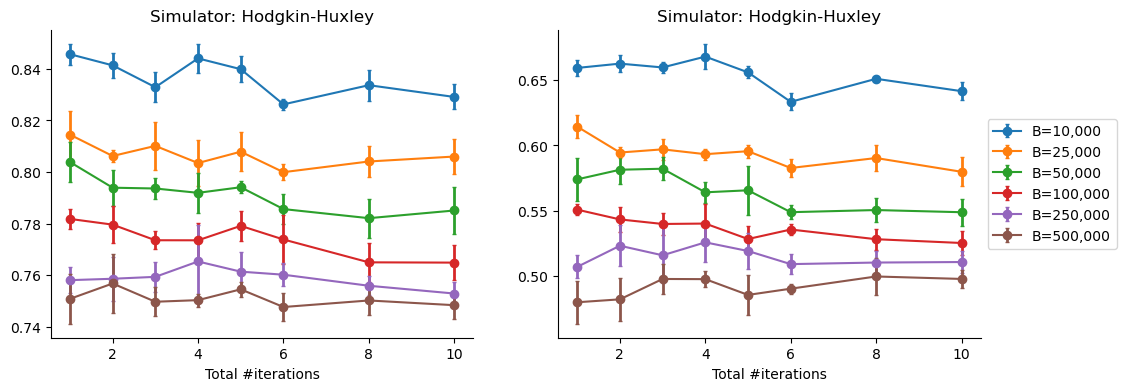

In [31]:
simulator = "Hodgkin-Huxley"
error_bars = True
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_function(c2st_array, ax=axes[0], legend=False, error_bars=error_bars)

plot_function(c2st_array_wo_first, ax=axes[1], legend=True, error_bars=error_bars)


# plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=1, ax=axes[1], legend=True, error_bars=error_bars)


In [26]:
def plot_function(array, budgets=BUDGETS, iters=ITERS, error_bars=False, legend=True, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    meansarr = np.mean(array, axis=2)
    stdsarr = np.std(array, axis=2)

    for bidx, b in enumerate(budgets):
        vals = meansarr[bidx]
        stds = stdsarr[bidx]
        if error_bars:
            ax.errorbar(x=iters, y=vals, yerr=stds, color=colors[bidx], capsize=1.5, elinewidth=2, fmt='o', linestyle='-', label=f"B={b:,}")
        else:
            ax.plot(iters, vals, 'o-', color=colors[bidx], label=f"B={b:,}")


    ax.set_title(f"Simulator: {simulator}")
    ax.set_xlabel("Total #iterations")
    # ax.set_ylabel(METRICS_LABELS[METRICS_NAMES[metric_idx]])
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    

In [28]:
c2st_array_wo_first_mean

array([[0.64159, 0.65106, 0.6334 , 0.65599, 0.66807, 0.65976, 0.66269,
        0.65939],
       [0.5798 , 0.59034, 0.58271, 0.59558, 0.59329, 0.597  , 0.59456,
        0.61439],
       [0.54881, 0.55048, 0.54884, 0.56561, 0.56407, 0.58215, 0.58137,
        0.57399],
       [0.52523, 0.52813, 0.53555, 0.52827, 0.54012, 0.53981, 0.5433 ,
        0.55079],
       [0.51064, 0.51025, 0.50904, 0.51909, 0.52573, 0.5158 , 0.52313,
        0.50693],
       [0.49769, 0.49957, 0.49021, 0.48544, 0.49753, 0.49766, 0.48205,
        0.47981]])

In [29]:
c2st_array_wo_first_std

array([[0.00698594, 0.00181725, 0.00662307, 0.00466105, 0.00986953,
        0.00422391, 0.00624895, 0.00631486],
       [0.01115504, 0.01027304, 0.00692672, 0.00493463, 0.00413756,
        0.00794462, 0.00428385, 0.00877111],
       [0.0103813 , 0.00924822, 0.00515843, 0.01877388, 0.00788154,
        0.00880511, 0.01096948, 0.01633216],
       [0.00932151, 0.00808249, 0.00409646, 0.00974452, 0.01525325,
        0.00834766, 0.00977839, 0.00412109],
       [0.00860572, 0.00883527, 0.00763187, 0.01361155, 0.01511127,
        0.02154463, 0.01564898, 0.0087203 ],
       [0.00659222, 0.01392083, 0.00382589, 0.01506995, 0.00605488,
        0.01159126, 0.01654518, 0.01644413]])